In [1]:
import sys
import os
# Add src directory to path
sys.path.append("../../src")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.helpers_news_movies import *

from nltk.corpus import stopwords
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import dask.dataframe as dd
import torch 


/Users/antoine/anaconda3/envs/gensim_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
ddf = dd.read_parquet('../../data/nyt_data.parquet')
# Filter dataset for a particular range
filtered_ddf = ddf[(ddf['year'] >= 1930) & (ddf['year'] <= 2015)]
# Reduce the dataset
filtered_ddf = filtered_ddf.sample(frac=0.01, random_state=1)
filtered_ddf = filtered_ddf.reset_index(drop=True)
# Combine the text and process it
filtered_ddf['combined_text'] = filtered_ddf['title'] + filtered_ddf['excerpt']
filtered_ddf['processed_text'] = filtered_ddf['combined_text'].apply(preprocess_text, meta=('processed_text', 'str'), args= ('stop_words_',))


In [15]:
print(filtered_ddf.head())
print(filtered_ddf.shape[0].compute())

   year                                              title  \
0  1992  The French observed the 50th anniversary today...   
1  1941                             30-LAP RACE TO JOSEPHS   
2  1974  Penn Central Co sues Fed Govt for $280-million...   
3  1989  LEAD:         *3*** COMPANY REPORTS **    *3* ...   
4  1968                                        Felder, A J   

                                             excerpt  \
0                                                      
1  He Overtakes Randolph in Midget Auto Event at ...   
2  says US ordered line to continue operating alt...   
3                                                      
4  Kirp, J: Found dead in car, upper Manhattan; p...   

                                       combined_text  \
0  The French observed the 50th anniversary today...   
1  30-LAP RACE TO JOSEPHSHe Overtakes Randolph in...   
2  Penn Central Co sues Fed Govt for $280-million...   
3  LEAD:         *3*** COMPANY REPORTS **    *3* ...   
4  Felder,

In [16]:
# Load the model
model_miniLM = SentenceTransformer("all-MiniLM-L6-v2")

In [17]:
# Load embedding or compute if not available

if os.path.exists('news_embeddings.npy'):
    news_embeddings = np.load('news_embeddings.npy')
    news_embeddings = torch.tensor(news_embeddings).to('mps')

else:
    news_embeddings = model_miniLM.encode(filtered_ddf['processed_text'].compute(), show_progress_bar=True, convert_to_tensor=True)
    np.save('news_embeddings.npy', news_embeddings.to('cpu').numpy())

print(news_embeddings.shape)

Batches: 100%|██████████| 4837/4837 [02:32<00:00, 31.72it/s] 


torch.Size([154753, 384])


In [11]:
# Raw queries to encode
# Queries
VIETNAM_WAR = "Vietnam"
COLD_WAR = "USSR"
IRAK_WAR = "Irak"
WW2 = "World War 2"
TECHNOLOGY = "technology"
ECONOMY = "economy"
HEALTH = "health"
GENDER_EQUALITY = "gender equality"
MIGRATION = "migration"

# Encode queries
query_vietnam = torch.tensor(model_miniLM.encode([VIETNAM_WAR])).to('mps')
query_cold_war = torch.tensor(model_miniLM.encode([COLD_WAR])).to('mps')
query_irak_war = torch.tensor(model_miniLM.encode([IRAK_WAR])).to('mps')
query_ww2 = torch.tensor(model_miniLM.encode([WW2])).to('mps')

query_technology = torch.tensor(model_miniLM.encode([TECHNOLOGY])).to('mps')
query_economy = torch.tensor(model_miniLM.encode([ECONOMY])).to('mps')
query_health = torch.tensor(model_miniLM.encode([HEALTH])).to('mps')
query_gender_equality = torch.tensor(model_miniLM.encode([GENDER_EQUALITY])).to('mps')
query_migration = torch.tensor(model_miniLM.encode([MIGRATION])).to('mps')

queries = [query_vietnam, query_cold_war, query_irak_war, query_ww2, query_technology, query_economy, query_health, query_gender_equality, query_migration]
column_names = ['vietnam', 'cold_war', 'irak_war', 'ww2', 'technology', 'economy', 'health', 'gender_equality', 'migration']

In [12]:
# Create a dataframe to store the cosine similarity
cosine_similarity_df = pd.DataFrame(columns=column_names)
# Add the index to the dataframe
cosine_similarity_df['index'] = filtered_ddf.index.compute()

# Compute cosine similarity for each query
for i, query in enumerate(queries):
    similarity = torch.nn.functional.cosine_similarity(news_embeddings, query)
    cosine_similarity_df[column_names[i]] = similarity.to('cpu').numpy()

# Add the year to the dataframe
cosine_similarity_df['year'] = filtered_ddf['year'].compute()
print(cosine_similarity_df.head())
print(cosine_similarity_df.shape)



    vietnam  cold_war  irak_war       ww2  technology   economy    health  \
0  0.117909  0.037860  0.074553  0.038982    0.140267  0.177040  0.059119   
1 -0.032902  0.105238 -0.016774  0.116058    0.056273 -0.053093 -0.038738   
2  0.086870  0.007099  0.109247  0.033148    0.009900 -0.008132 -0.030397   
3  0.049801 -0.000606 -0.066392 -0.004424    0.018586  0.017684 -0.003461   
4  0.044270  0.047596  0.093585  0.182407    0.114580  0.097076  0.123221   

   gender_equality  migration  index  year  
0         0.063235   0.070957      0  1984  
1        -0.067979   0.031544      1  2014  
2         0.038546   0.030915      2  1993  
3         0.018702  -0.081410      3  2015  
4         0.123060   0.014255      4  2009  
(66071, 11)


In [9]:
# Save the dataframe
cosine_similarity_df.to_csv('../../data/df_news/cosine_similarity_news.csv', index=True)
# Make a boolean version of the dataframe with a threshold of 0.3
cosine_similarity_df_bool = cosine_similarity_df.copy()
cosine_similarity_df_bool = cosine_similarity_df_bool.drop(columns=['index', 'year'])
cosine_similarity_df_bool = cosine_similarity_df_bool > 0.2
cosine_similarity_df_bool['year'] = cosine_similarity_df['year']


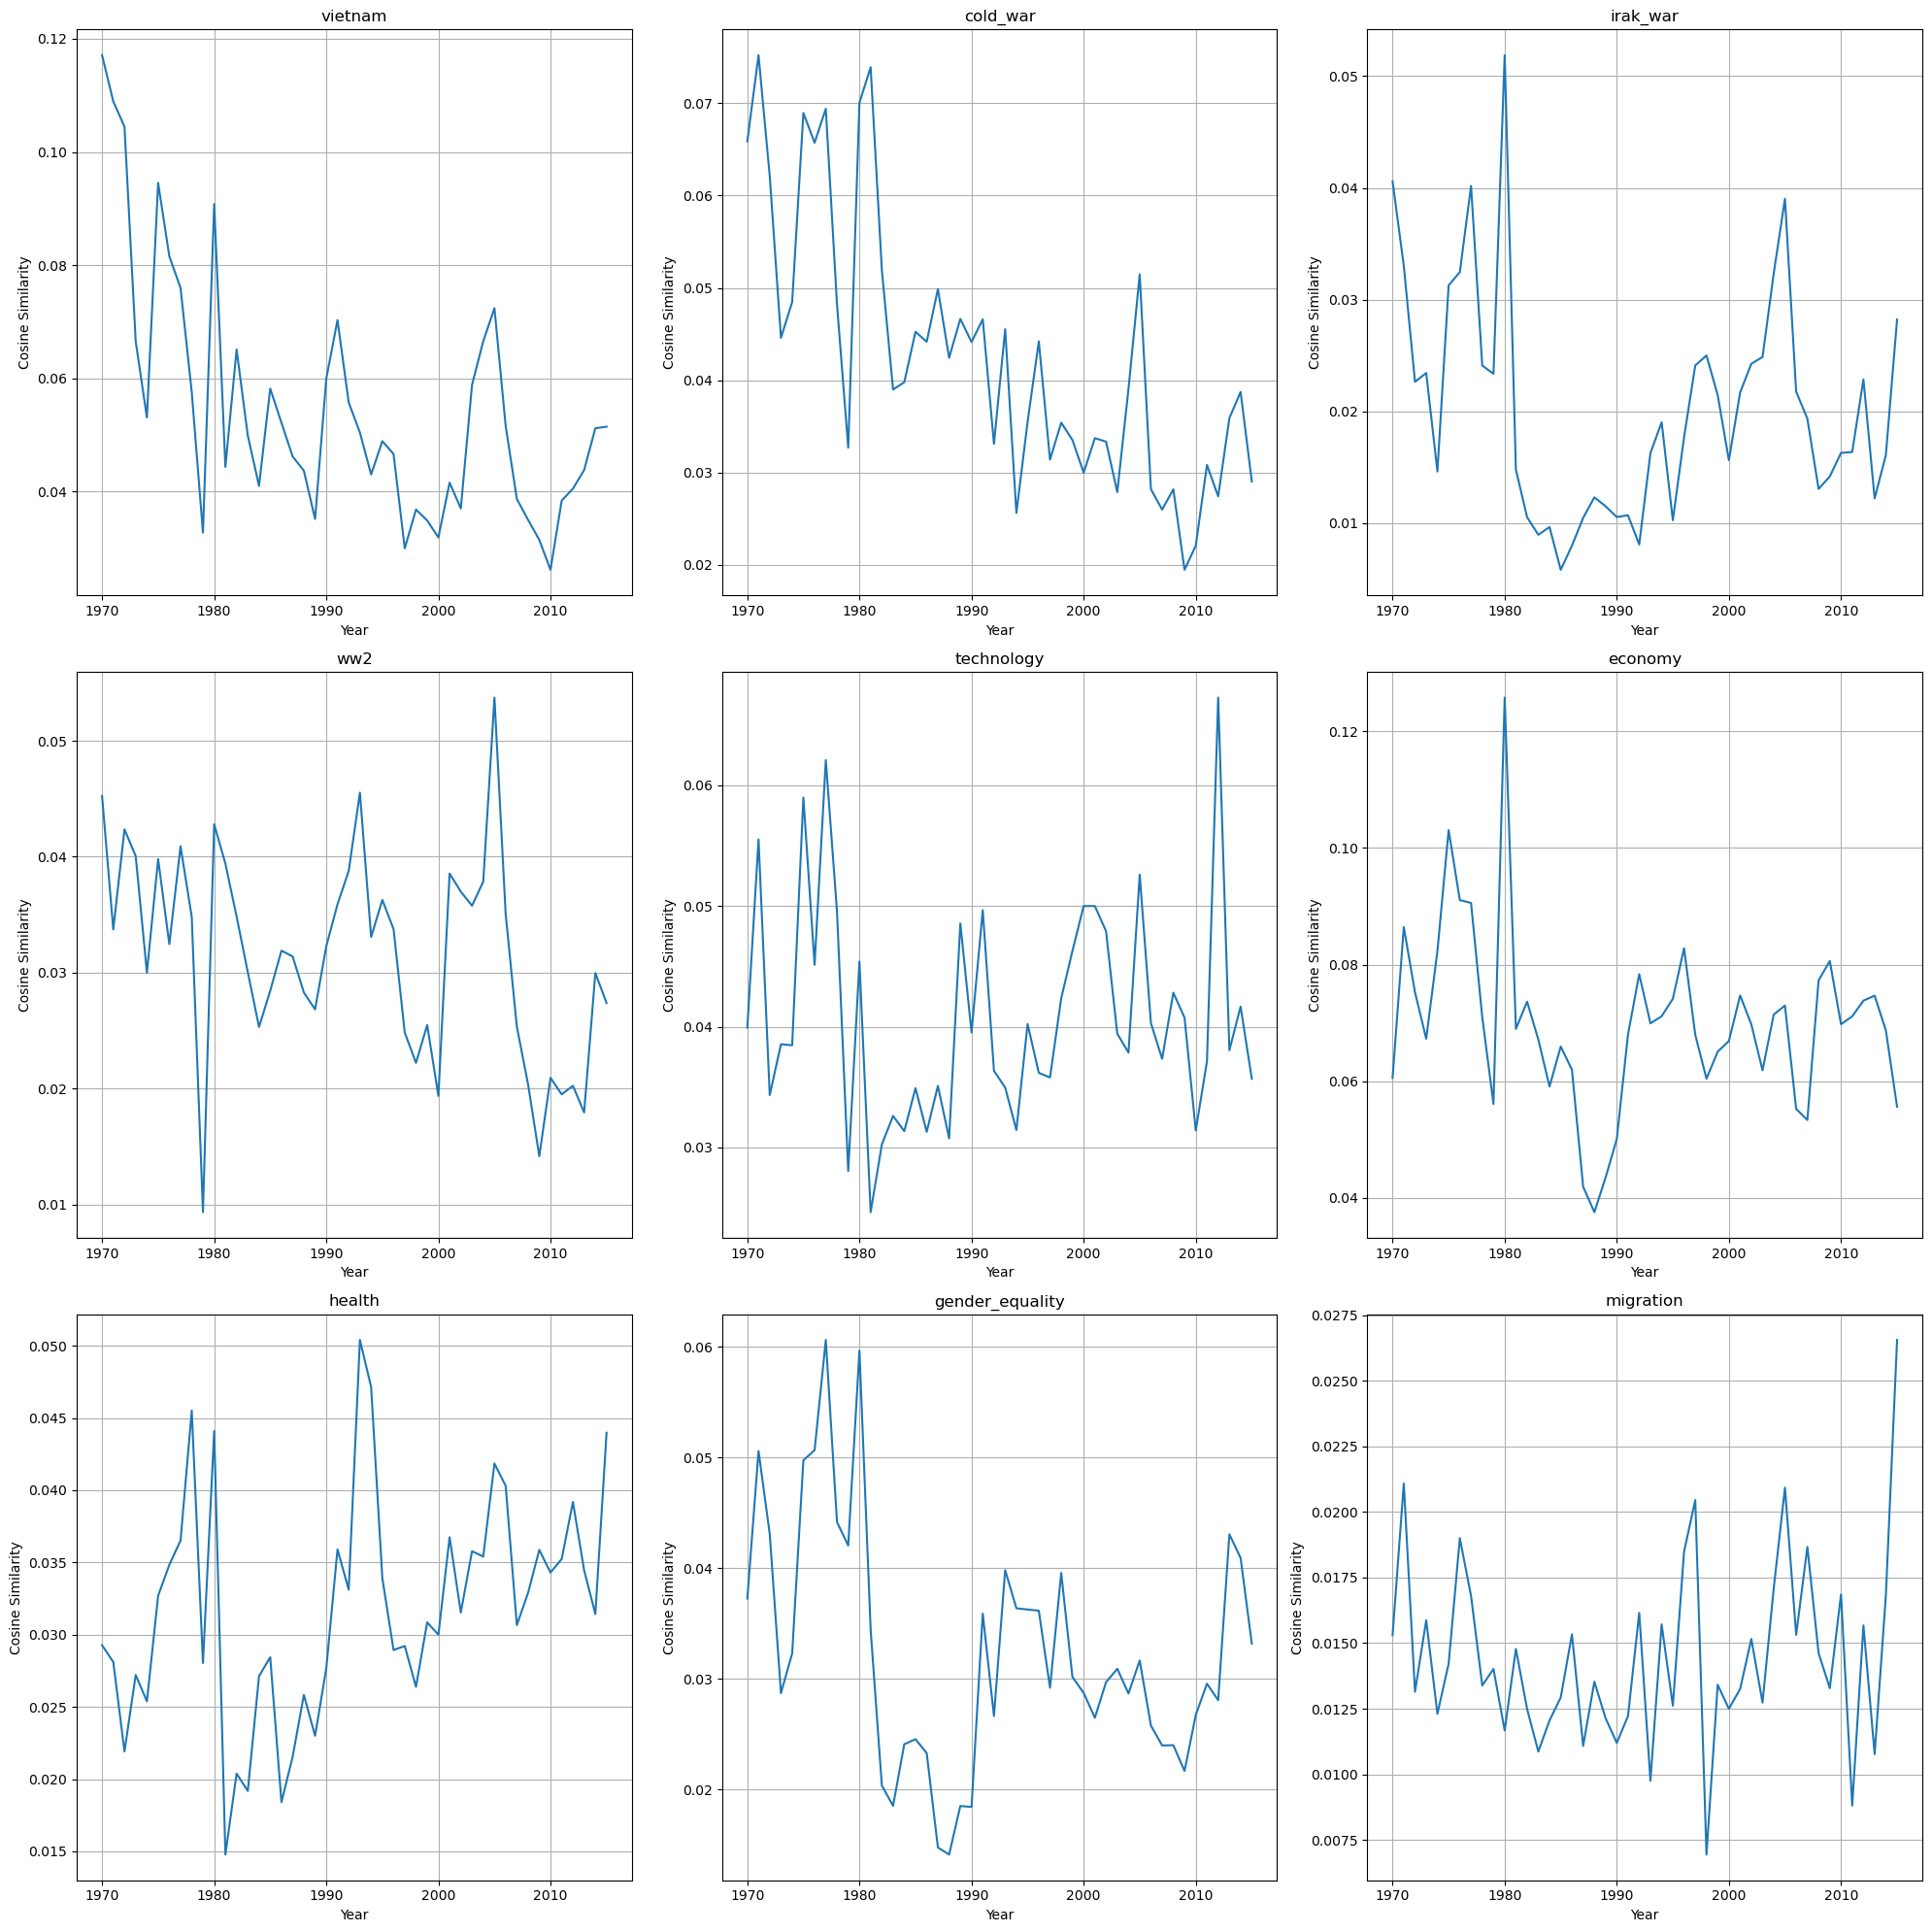

In [13]:
# Number of articles per year
articles_per_year = filtered_ddf['year'].value_counts().compute()
# Plot the cosine similarity for each query over time

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i, column in enumerate(column_names):
    row = i // 3
    col = i % 3
    # Sum the boolean values for each year
    cosine_similarity_df_bool_grouped = cosine_similarity_df_bool.groupby('year').sum()
    # Normalize the values by the number of articles in the year
    cosine_similarity_df_bool_grouped = cosine_similarity_df_bool_grouped.div(articles_per_year, axis=0)
    ax[row, col].plot(cosine_similarity_df_bool_grouped.index, cosine_similarity_df_bool_grouped[column])
    ax[row, col].set_title(column)
    ax[row, col].set_xlabel('Year')
    ax[row, col].set_ylabel('Cosine Similarity')
    ax[row, col].grid()
plt.tight_layout()
plt.savefig('../../figures/news/cosine_similarity_news.png')

plt.show()